In [ ]:
# Install some common data analysis packages
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install pandasql

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import pandasql as pdsql

In [2]:
#Import all data available at the hackathon
printer_data = pd.read_csv('http://ocf.io/shichenh/ocf_datathon_ds/printing.csv')
session_data = pd.read_csv('https://www.ocf.berkeley.edu/~shichenh/ocf_datathon_ds/sessions.csv')
staff_data = pd.read_csv('https://www.ocf.berkeley.edu/~shichenh/ocf_datathon_ds/s_sessions.csv')

In [3]:
#Trim the printer data to have no entries past the time 2017-11-09 20:00:00 UTC (Noon pacific)
#Also, no entries before 9AM Pacific 2016-03-16
printer_data = printer_data[39:194767]

#Trim the session data to have no entries past the time 2017-11-09 20:00:00 UTC (noon pacific)
#Also, no entries before 16:00:00 UTC
session_data = session_data[156305:302446]


In [4]:
#Convert dates and times into a datetime object
session_data['start'] = pd.to_datetime(session_data['start'], format='%Y-%m-%dT%H:%M:%SZ')
session_data['end'] = pd.to_datetime(session_data['end'], format='%Y-%m-%dT%H:%M:%SZ')
printer_data['time'] = pd.to_datetime(printer_data['time'], format='%Y-%m-%d %H:%M:%S')

#Give all the dates and times a format which can be compared using string comparison
printer_data['strtime'] = printer_data['time'].dt.tz_localize('US/Pacific').dt.tz_convert('utc')
printer_data['strtime'].apply(lambda x: x.strftime("%Y:%m:%d:%H:%M:%S"))

session_data['start'] = session_data['start'].dt.tz_localize('utc')
session_data['start'].apply(lambda x: x.strftime("%Y:%m:%d:%H:%M:%S"))

session_data['end'] = session_data['end'].dt.tz_localize('utc')
session_data['end'].apply(lambda x: x.strftime("%Y:%m:%d:%H:%M:%S"))

#Prevent any output from showing in the ipython notebook
print("")

In [5]:
#Convert some columns from objects to strings
session_data.user.apply(str)
printer_data.user.apply(str)

printer_data['strtime'] = printer_data['strtime'].astype(str)
session_data['start'] = session_data['start'].astype(str)
session_data['end'] = session_data['end'].astype(str)

print("")

In [6]:
#Create a SQL Query which will be able to merge the two datasets together
query = """SELECT * FROM session_data a INNER JOIN printer_data b 
            ON a.user = b.user WHERE a.start < b.strtime AND a.end > b.strtime"""

#Convert the tables into a SQL database and merge using SQL
#This is much more efficient than converting in python

pysql = lambda q: pdsql.sqldf(q, globals())
merged_table = pysql(query)

In [7]:
#Remove columns which are not necessary to answer the question I would like to answer
merged_table = merged_table.drop(columns=['host', 'last_update', 
                                          'Unnamed: 0', 'queue', 'date', 
                                          'weekday', 'strtime'])

In [8]:
#Rename columns and drop the repeated column
merged_table.columns = ['id', 'user', 'start', 
                        'end', 'duration', 'time', 
                        'pages', 'user2']
merged_table = merged_table.drop(columns=['user2'])

In [9]:
#Sum print jobs in the same session to get total pages printed
#Solves the problem of 2 print jobs in the same session treated as 2 different sessions
query = """ SELECT *, SUM(pages) FROM merged_table t GROUP BY start
"""

pysql = lambda q: pdsql.sqldf(q, globals())
printer_usage = pysql(query)

In [10]:
#Clean the data
printer_usage.rename(columns={'SUM(pages)' : 'total_printed'}, inplace=True)
printer_usage.drop(columns=['pages'])
print('')

In [11]:
#Describe the set of all sessions where a printer was used
#Important features are mean, 50%, and 75%
print_sessions = printer_usage.query('total_printed >= 1')
print_sessions.describe()

,id,duration,pages,total_printed
count,97320.000000,97320.000000,97320.000000,97320.000000
mean,224950.669934,15.471843,3.656237,6.060173
std,42169.116490,49.189003,3.369595,6.009940
min,156307.000000,0.100000,0.000000,1.000000
25%,189149.750000,2.816667,1.000000,2.000000
50%,220556.500000,5.350000,2.000000,5.000000
75%,261267.250000,11.866667,5.000000,8.000000
max,302441.000000,3504.983333,254.000000,600.000000


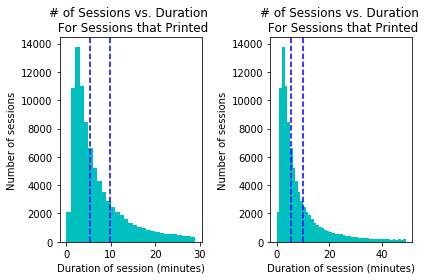

In [12]:
#Display two histograms to help us better visualize the data
#Also plot the mean and 70th percentile in the histogram
bins_50 = [i for i in range(0,50)]
bins_30 = [i for i in range(0, 30)]

p_70 = np.percentile(print_sessions['duration'], 70)
p_50 = np.percentile(print_sessions['duration'], 50)

plt.subplot(121)
plt.hist(print_sessions['duration'], bins=bins_30, color='c')
plt.axvline(p_70, color='b', linestyle='dashed')
plt.axvline(p_50, color='b', linestyle='dashed')
plt.xlabel('Duration of session (minutes)')
plt.ylabel('Number of sessions')
plt.title('# of Sessions vs. Duration \n For Sessions that Printed')

plt.subplot(122)
plt.hist(print_sessions['duration'], bins=bins_50, color='c')
plt.axvline(p_70, color='b', linestyle='dashed')
plt.axvline(p_50, color='b', linestyle='dashed')
plt.xlabel('Duration of session (minutes)')
plt.ylabel('Number of sessions')

plt.title('# of Sessions vs. Duration \n For Sessions that Printed')
plt.tight_layout()
plt.show()

In [13]:
#Created by Alex Welty on Nov. 11, 2017
#Last updated on Nov. 22, 2017